In [1]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tslearn.utils import to_time_series_dataset
import biosppy.signals.ecg as ecg
import matplotlib.pyplot as plt
import neurokit2 as nk
import heartpy as hp
from statistics import mean
import functions
from multiprocessing import Pool
from datetime import time
from pandarallel import pandarallel
import functions
import scipy
import math
import pywt
import operator
from functions import *
import itertools
from sklearn.ensemble import ExtraTreesClassifier


In [2]:
folder = ""
raw = folder + "raw_data/"
x_train = pd.read_csv('x_train_preprocess.csv')
x_test = pd.read_csv('x_test_preprocess.csv')
y_train = pd.read_csv(raw + 'y_train.csv', index_col=['id'])
x_train = x_train.fillna(0)
x_test = x_test.fillna(0)

In [3]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5117 entries, 0 to 5116
Columns: 1009 entries, Unnamed: 0 to nk_feat_387
dtypes: float64(1008), int64(1)
memory usage: 39.4 MB


In [4]:
selector = SelectKBest(score_func=f_classif, k=100)
selector.fit(np.array(x_train), np.array(y_train).squeeze())
cols = selector.get_support(indices=True)

/home/francescog/Scaricati/AML_Pr_2/venv/lib/python3.8/site-packages/sklearn/feature_selection/_univariate_selection.py:110: UserWarning: Features [72] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)


In [5]:
#x_train= x_train.iloc[:,cols]
#x_test = x_test.iloc[:,cols]

In [6]:
#scale data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

In [11]:
extra_t = ExtraTreesClassifier(n_estimators=1000, random_state=0)

In [12]:
#cross validation score
scores = cross_val_score(extra_t, x_train, np.ravel(y_train), cv=10, scoring='f1_micro',n_jobs=-1)
print(scores.mean())
print(scores.std())
#0.6884819135273974 StandardScaler
#0.6888721563111547 / 0.013991806236182297 MinMaxScaler
#0.6904373318248532 / 0.013802028070542137 new preprocessing
#0.6998173006360078/ 0.009557202344616872 new new preprocessing
#0.7009872645547945/ 0.013523219024517932 378 new feat
#0.7506291279354207 / 0.01150289103654465  1000 feat

0.7506291279354207
0.01150289103654465


In [13]:
import pickle
filename = 'models/extra_model.sav'
pickle.dump(extra_t, open(filename, 'wb'))


In [14]:
extra_t.fit(x_train, np.ravel(y_train))
y_test = extra_t.predict(x_test)
data_y_test = {
    'id': [i for i in range(len(y_test))],
    'y': y_test
}
df_y_test = pd.DataFrame(data_y_test)
df_y_test.to_csv('outputs/output_extra.csv', index=False)

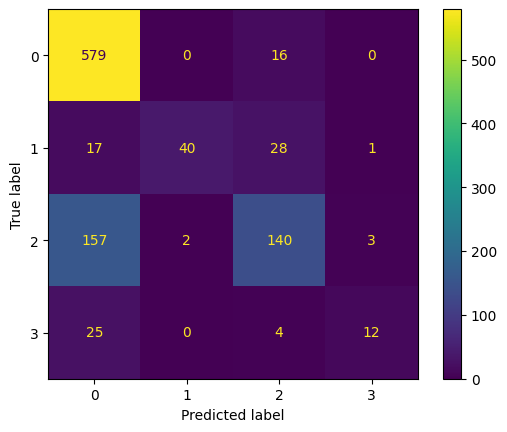

In [16]:
x_train_2, x_val, y_train_2, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
extra_t.fit(x_train_2, np.ravel(y_train_2))
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn import metrics
y_pred = extra_t.predict(x_val)
cm = metrics.confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=extra_t.classes_)
disp.plot()
plt.show()